In [131]:
import pandas as pd
import pickle
import json
import seaborn as sns
import pprint
import numpy as np
import math
import ast
pp = pprint.PrettyPrinter(depth=6)
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (14.0, 5.0)
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 450)

In [132]:
pkl_folder = "../../pkl"
csv_folder = "../../csv"
figure_folder = "../../figures"

# Goal

Calculate ci metrics for each release and output a dataset with one entry for release and a list of metrics as features

In [133]:
tags = pd.read_csv(f"{csv_folder}/tags_updated.csv", index_col=0)
tags.Date = pd.to_datetime(tags.Date)
tags.head(2)

,actual_release_date,Tag,Sha,Date,month,year,major_version,jira_version
0,NaN,4.5.6,12d931e5a31e1692a428bbb34ba11cd63aebf998,2015-10-16 09:31:18,10,2015,4,4.5.6
1,NaN,4.5.7,e2afb0bff1b8be759789d2c1bc9348de6f519f83,2016-04-08 13:44:39,4,2016,4,4.5.7


### Import builds and jobs

In [134]:
builds = pd.read_csv(f"{csv_folder}/builds_cleaned.csv", index_col=0)
builds.head(2)

,number,pull_request_number,id,event_type,finished_at,pull_request_title,started_at,duration,state,started_at_day,started_at_month,started_at_year
0,6995,NaN,99118995,push,2015-12-28 16:34:08+00:00,NaN,2015-12-28 16:18:41+00:00,5361.0,failed,28.0,12.0,2015.0
1,6994,NaN,99100662,push,2015-12-28 14:36:03+00:00,NaN,2015-12-28 14:18:30+00:00,5953.0,passed,28.0,12.0,2015.0


In [135]:
jobs = pd.read_csv(f"{csv_folder}/allJobs.csv", index_col=0)
for datefield in ["started_at","created_at","finished_at","updated_at"]:
    jobs[f"{datefield}"] = pd.to_datetime(jobs[f"{datefield}"])
jobs.shape

(136983, 13)

### Import tag comparison pairs

In [136]:
tags_comparison = pd.read_csv(f"{csv_folder}/tags_comparison_final_updated_no_rc_and_milestones.csv", index_col=0)
tags_comparison.from_commit_date = pd.to_datetime(tags_comparison.from_commit_date)
tags_comparison.to_commit_date = pd.to_datetime(tags_comparison.to_commit_date)
tags_comparison.from_author_date = pd.to_datetime(tags_comparison.from_author_date)
tags_comparison.to_author_date = pd.to_datetime(tags_comparison.to_author_date)
tags_comparison = tags_comparison[2:]
tags_comparison[["from_tag", "to_tag"]]

,from_tag,to_tag
2,5.1.1,5.1.2
3,5.1.2,5.2
4,5.2,5.3
5,5.3,5.4
6,5.4,5.5
7,5.5,5.6
8,5.6,5.6.1
9,5.6.1,5.6.2
10,5.6.1,6.0
11,5.6.2,5.6.3


## Import release commits

In [137]:
def replace_tags_with_jira(df):
    df = df.merge(tags[["Tag","jira_version"]], left_on="to_tag", right_on="Tag")\
    .drop(columns=["to_tag", "Tag"]).rename(columns={"jira_version":"to_tag"})
    df = df.merge(tags[["Tag","jira_version"]], left_on="from_tag", right_on="Tag")\
    .drop(columns=["from_tag", "Tag"]).rename(columns={"jira_version":"from_tag"})
    return df

### Import tags difference commits (git log tag1...tag2) (1)

In [138]:
tags_comparison_commits = pd.read_csv(f"{csv_folder}/tags_comparison_commits_no_rc_and_milestones.csv", index_col=0)
tags_comparison_commits.tail(2)

,from_tag,to_tag,ahead_sha
15603,8.4.1,8.4.2,7721c3eeab3202e91fb9c87dfaec4ba3a7b4d0df
15604,8.4.1,8.4.2,fd2cb0c84d052b9ea773503be71a3bb3cda13cd6


In [139]:
tags_comparison_commits  = replace_tags_with_jira(tags_comparison_commits)
tags_comparison_commits.rename(columns={"ahead_sha": "commitsha"}, inplace=True)
tags_comparison_commits.tail(2)

,commitsha,to_tag,from_tag
14711,93bf42f81310013436f2d5ef60b60d8714a32f5f,7.9.4,7.9.3
14712,28394f222603b43aadc132ec7e814bc6a5cd8edb,7.9.4,7.9.3


In [140]:
tags_comparison_commits.shape

(14713, 3)

### Import tags commits (1) + iterative PRs

In [141]:
tags_iterative_pr_commits = pd.read_csv(f"{csv_folder}/commits_for_tags/tags_pairs_iterative_commits.csv", index_col=0)
tags_iterative_pr_commits.tail(2)

,from_tag,to_tag,commitsha
122451,8.4.1.35646,8.4.2.36762,ed1a72601c559e86ccd96004c99157421b6bcb20
122452,8.4.1.35646,8.4.2.36762,7721c3eeab3202e91fb9c87dfaec4ba3a7b4d0df


In [142]:
tags_iterative_pr_commits  = replace_tags_with_jira(tags_iterative_pr_commits)
tags_iterative_pr_commits.tail(2)

,commitsha,to_tag,from_tag
122451,ed1a72601c559e86ccd96004c99157421b6bcb20,8.4.2,8.4.1
122452,7721c3eeab3202e91fb9c87dfaec4ba3a7b4d0df,8.4.2,8.4.1


In [143]:
tags_iterative_pr_commits.shape

(122453, 3)

### Import tags commits the ones nor in (1) or (2) assigned using Jira FixVersion for the issue in commitmessage

In [144]:
tags_fix_commits = pd.read_csv(f"{csv_folder}/commits_for_tags/tags_fix_commits.csv", index_col=0)
tags_fix_commits.tail(2)

,from_tag,to_tag,commitsha
3245,8.4,8.4.1,34a0bc1a4e14e13a7d40a410b268d6ea7b0f3a40
3246,8.4.1,8.4.2,df64c184d1427f74592459b42093e8b0b6878c98


In [145]:
tags_fix_commits.shape

(3247, 3)

# Start

In [229]:
job_parsed = pd.read_csv(f"{csv_folder}/job_log_parsed/final/jobs_log_metrics_final.csv", index_col=0)
#
job_parsed.shape

(136983, 18)

In [230]:
job_parsed.columns

Index(['job_id', 'build_target', 'build_tool',
       'build_canceled_open_pr_on_branch', 'errors', 'failures',
       'suspected_words', 'warnings', 'skipped_words', 'lines', 'words',
       'exceptions', 'error_classes', 'tests_total', 'tests_passed',
       'tests_failed', 'tests_skipped', 'failed_tasks'],
      dtype='object')

In [231]:
job_parsed.exceptions = job_parsed.exceptions.apply(ast.literal_eval)
job_parsed.error_classes = job_parsed.error_classes.apply(ast.literal_eval)
job_parsed.failed_tasks = job_parsed.failed_tasks.apply(ast.literal_eval)
job_parsed["build_tool_str"] = job_parsed.build_tool
job_parsed.build_tool = job_parsed.build_tool.apply(ast.literal_eval)

In [232]:
job_parsed["n_exceptions"] = job_parsed.exceptions.apply(lambda x: len(x))
job_parsed["n_error_classes"] = job_parsed.error_classes.apply(lambda x: len(x))
job_parsed["n_build_tools"] = job_parsed.build_tool.apply(lambda x: len(x))

In [233]:
job_parsed["maven_build"] = job_parsed.build_tool.apply(lambda x: "maven" in x)
job_parsed["gradle_build"] = job_parsed.build_tool.apply(lambda x: "gradle" in x)
job_parsed["mocha_build"] = job_parsed.build_tool.apply(lambda x: "mocha" in x)
job_parsed["jest_build"] = job_parsed.build_tool.apply(lambda x: "jest" in x)
job_parsed["grunt_build"] = job_parsed.build_tool.apply(lambda x: "grunt" in x)
job_parsed["yarn_build"] = job_parsed.build_tool.apply(lambda x: "yarn" in x)
job_parsed["node_build"] = job_parsed.build_tool.apply(lambda x: "node" in x)

In [234]:
job_parsed.head(2)

,job_id,build_target,build_tool,build_canceled_open_pr_on_branch,errors,failures,suspected_words,warnings,skipped_words,lines,words,exceptions,error_classes,tests_total,tests_passed,tests_failed,tests_skipped,failed_tasks,build_tool_str,n_exceptions,n_error_classes,n_build_tools,maven_build,gradle_build,mocha_build,jest_build,grunt_build,yarn_build,node_build
0,346751001,WEB_TESTS,[yarn],False,3.0,2.0,1.0,2.0,1.0,1045.0,3294.0,[],[],1120.0,1117.0,0.0,3.0,[],['yarn'],0,0,1,False,False,False,False,False,True,False
1,575471642,WEB_TESTS,"[yarn, jest, gradle]",False,3.0,2.0,1.0,9.0,1.0,1362.0,3919.0,[],[],2006.0,2005.0,0.0,1.0,[],"['yarn', 'jest', 'gradle']",0,0,3,False,True,False,True,False,True,False


In [235]:
job_parsed.shape

(136983, 29)

In [236]:
job_parsed = job_parsed.merge(jobs, left_on="job_id", right_on="id")
job_parsed["year_month"] = job_parsed.apply(lambda row: f"{row.started_at.year}/{str(row.started_at.month).zfill(2)}", axis=1)
job_parsed = job_parsed.drop_duplicates(subset=["job_id"], keep='first')
job_parsed.shape

(136983, 43)

**Describe**

In [237]:
job_parsed.describe()

,job_id,errors,failures,suspected_words,warnings,skipped_words,lines,words,tests_total,tests_passed,tests_failed,tests_skipped,n_exceptions,n_error_classes,n_build_tools,id,buildid,number,commitid
count,1.369830e+05,136983.000000,136983.000000,136983.000000,136983.000000,136983.000000,136983.000000,1.369830e+05,136983.000000,136983.000000,136983.000000,136983.000000,136983.000000,136983.000000,136983.000000,1.369830e+05,1.369830e+05,136983.000000,1.369830e+05
mean,1.605672e+08,392.526868,350.997080,34.361906,119.294489,395.542805,8013.431594,5.093868e+04,2226.276728,2223.503033,0.393027,2.380668,17.532424,0.769913,1.050846,1.605672e+08,1.605672e+08,14131.256792,4.639438e+07
std,9.339884e+07,750.253759,728.512991,144.815604,249.359894,672.734628,10409.808351,6.733393e+04,4294.401008,4294.073989,8.738932,8.219820,41.049539,6.010763,0.874099,9.339884e+07,9.339884e+07,10802.638198,2.808363e+07
min,5.473113e+07,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.473113e+07,5.473112e+07,1.100000,1.569590e+07
25%,8.808975e+07,1.000000,1.000000,1.000000,1.000000,0.000000,885.000000,3.007000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.808975e+07,8.808973e+07,5702.850000,2.505123e+07
50%,1.280068e+08,7.000000,7.000000,6.000000,39.000000,53.000000,3992.000000,1.845800e+04,64.000000,62.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.280068e+08,1.280068e+08,9894.400000,3.622591e+07
75%,2.212873e+08,243.000000,67.000000,22.000000,66.000000,419.000000,12655.500000,8.707150e+04,1075.000000,1072.000000,0.000000,1.000000,28.000000,0.000000,1.000000,2.212873e+08,2.212873e+08,21510.650000,6.380080e+07
max,7.313960e+08,14202.000000,26330.000000,5853.000000,6958.000000,4453.000000,176933.000000,1.107320e+06,30982.000000,30980.000000,1637.000000,2021.000000,3555.000000,936.000000,4.000000,7.313960e+08,7.313960e+08,39427.200000,2.259581e+08


In [238]:
job_parsed.columns

Index(['job_id', 'build_target', 'build_tool',
       'build_canceled_open_pr_on_branch', 'errors', 'failures',
       'suspected_words', 'warnings', 'skipped_words', 'lines', 'words',
       'exceptions', 'error_classes', 'tests_total', 'tests_passed',
       'tests_failed', 'tests_skipped', 'failed_tasks', 'build_tool_str',
       'n_exceptions', 'n_error_classes', 'n_build_tools', 'maven_build',
       'gradle_build', 'mocha_build', 'jest_build', 'grunt_build',
       'yarn_build', 'node_build', 'id', 'buildid', 'started_at', 'created_at',
       'finished_at', 'number', 'state', 'updated_at', 'commitsha', 'commitid',
       'commitmessage', 'commitref', 'commitcompare_url', 'year_month'],
      dtype='object')

**Nan values**

In [239]:
job_parsed.isna().sum()

job_id                                  0
build_target                        55425
build_tool                              0
build_canceled_open_pr_on_branch        0
errors                                  0
failures                                0
suspected_words                         0
warnings                                0
skipped_words                           0
lines                                   0
words                                   0
exceptions                              0
error_classes                           0
tests_total                             0
tests_passed                            0
tests_failed                            0
tests_skipped                           0
failed_tasks                            0
build_tool_str                          0
n_exceptions                            0
n_error_classes                         0
n_build_tools                           0
maven_build                             0
gradle_build                      

In [240]:
job_parsed[job_parsed.lines == 1].shape

(10148, 43)

In [241]:
len(job_parsed[job_parsed.lines == 1]) / len(job_parsed)

0.07408218538066767

In [160]:
job_parsed.describe()

,job_id,errors,failures,suspected_words,warnings,skipped_words,lines,words,tests_total,tests_passed,tests_failed,tests_skipped,n_exceptions,n_error_classes,n_build_tools,id,buildid,number,commitid
count,1.369830e+05,136983.000000,136983.000000,136983.000000,136983.000000,136983.000000,136983.000000,1.369830e+05,136983.000000,136983.000000,136983.000000,136983.000000,136983.000000,136983.000000,136983.000000,1.369830e+05,1.369830e+05,136983.000000,1.369830e+05
mean,1.605672e+08,392.526868,350.997080,34.361906,119.294489,395.542805,8013.431594,5.093868e+04,2226.271165,2223.497470,0.393027,2.380668,17.532424,0.769913,1.050846,1.605672e+08,1.605672e+08,14131.256792,4.639438e+07
std,9.339884e+07,750.253759,728.512991,144.815604,249.359894,672.734628,10409.808351,6.733393e+04,4294.403881,4294.076858,8.738932,8.219820,41.049539,6.010763,0.874099,9.339884e+07,9.339884e+07,10802.638198,2.808363e+07
min,5.473113e+07,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.473113e+07,5.473112e+07,1.100000,1.569590e+07
25%,8.808975e+07,1.000000,1.000000,1.000000,1.000000,0.000000,885.000000,3.007000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.808975e+07,8.808973e+07,5702.850000,2.505123e+07
50%,1.280068e+08,7.000000,7.000000,6.000000,39.000000,53.000000,3992.000000,1.845800e+04,64.000000,62.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.280068e+08,1.280068e+08,9894.400000,3.622591e+07
75%,2.212873e+08,243.000000,67.000000,22.000000,66.000000,419.000000,12655.500000,8.707150e+04,1075.000000,1072.000000,0.000000,1.000000,28.000000,0.000000,1.000000,2.212873e+08,2.212873e+08,21510.650000,6.380080e+07
max,7.313960e+08,14202.000000,26330.000000,5853.000000,6958.000000,4453.000000,176933.000000,1.107320e+06,30982.000000,30980.000000,1637.000000,2021.000000,3555.000000,936.000000,4.000000,7.313960e+08,7.313960e+08,39427.200000,2.259581e+08


In [161]:
job_parsed[job_parsed.n_exceptions >0]

,job_id,build_target,build_tool,build_canceled_open_pr_on_branch,errors,failures,suspected_words,warnings,skipped_words,lines,words,exceptions,error_classes,tests_total,tests_passed,tests_failed,tests_skipped,failed_tasks,build_tool_str,n_exceptions,n_error_classes,n_build_tools,maven_build,gradle_build,mocha_build,jest_build,grunt_build,yarn_build,node_build,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url,year_month
3,575471640,BUILD,"[yarn, node, jest, gradle]",False,3.0,5.0,7.0,13.0,11.0,2138.0,8162.0,"[FileNotFound, FileNotFound]",[],0.0,0.0,0.0,0.0,[],"['yarn', 'node', 'jest', 'gradle']",2,0,4,False,True,False,True,False,True,True,575471640,575471639,2019-08-22 18:21:54+00:00,2019-08-22 18:21:19.419000+00:00,2019-08-22 18:40:58+00:00,39085.1,passed,2019-08-22 18:40:58.508000+00:00,7c2a234b30826c8f98dabff8506b1f49884b83a5,174121400,DOCS Add instructions for Application to a Por...,refs/heads/master,https://github.com/SonarSource/sonarqube/compa...,2019/08
8,483557470,BUILD,"[yarn, node, jest, gradle]",False,2.0,5.0,3.0,12.0,0.0,1817.0,7496.0,"[FileNotFound, FileNotFound]",[],6.0,6.0,0.0,0.0,[],"['yarn', 'node', 'jest', 'gradle']",2,0,4,False,True,False,True,False,True,True,483557470,483557469,2019-01-23 19:21:55+00:00,2019-01-23 19:21:25.852000+00:00,2019-01-23 19:47:24+00:00,38847.1,passed,2019-01-23 19:47:24.747000+00:00,3dc969856b59dc52b5b2e855d8b2387d4670ff36,145686653,DOCS formatting glitches & minor rewording (#1...,refs/pull/3187/merge,https://github.com/SonarSource/sonarqube/pull/...,2019/01
9,354189359,BUILD,"[yarn, node, gradle]",False,3.0,1.0,40.0,188.0,0.0,2931.0,9517.0,"[Expected, Expected, Expected]",[],0.0,0.0,0.0,0.0,[],"['yarn', 'node', 'gradle']",3,0,3,False,True,False,False,False,True,True,354189359,354189358,2018-03-16 07:12:27+00:00,2018-03-16 07:11:50.381000+00:00,2018-03-16 07:38:06+00:00,38262.1,passed,2018-06-04 08:38:21.036000+00:00,98eb519207bea6c9bb3cc4a09419ec044cc2336c,105488877,SONAR-10439 Fix it test 2,refs/pull/3141/merge,https://github.com/SonarSource/sonarqube/pull/...,2018/03
16,721125401,BUILD,"[yarn, node, gradle]",False,100.0,4.0,38.0,60.0,46.0,9523.0,60646.0,[FileNotFound],[],0.0,0.0,0.0,0.0,[],"['yarn', 'node', 'gradle']",1,0,3,False,True,False,False,False,True,True,721125401,721125400,2020-08-25 20:08:12+00:00,2020-08-25 20:06:58.573000+00:00,2020-08-25 20:45:13+00:00,39397.1,passed,2020-08-25 20:45:13.702000+00:00,60c64b2c9f95bb52d070758fa88a3881ae69b5e7,222268239,SONAR-13766 PostProjectAnalysisTask's 'descrip...,refs/heads/master,https://github.com/SonarSource/sonarqube/compa...,2020/08
17,353370269,BUILD,"[yarn, node, gradle]",False,3.0,1.0,40.0,188.0,2.0,2937.0,9520.0,"[Expected, Expected, Expected]",[],0.0,0.0,0.0,0.0,[],"['yarn', 'node', 'gradle']",3,0,3,False,True,False,False,False,True,True,353370269,353370268,2018-03-14 14:54:36+00:00,2018-03-14 14:54:03.085000+00:00,2018-03-14 15:23:35+00:00,38188.1,passed,2018-06-04 08:20:28.096000+00:00,75f89f1c2042e9b2c5bc6146bd15a051f08b3cd4,105230203,fixup! SONAR-10346 fix DB migration,refs/pull/3148/merge,https://github.com/SonarSource/sonarqube/pull/...,2018/03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136976,620789741,BUILD,"[yarn, node, gradle]",False,2.0,2.0,4.0,3.0,8.0,2136.0,8148.0,[FileNotFound],[],0.0,0.0,0.0,0.0,[],"['yarn', 'node', 'gradle']",1,0,3,False,True,False,False,False,True,True,620789741,620789740,2019-12-04 19:46:57+00:00,2019-12-04 19:46:24.446000+00:00,2019-12-04 20:23:17+00:00,39185.1,passed,2019-12-04 20:23:17.136000+00:00,5903d90c057cf58c17e32b4c5c20f87dd8e4f452,188691386,SONAR-12367 Show total issues in codeviewer he...,refs/heads/master,https://github.com/SonarSource/sonarqube/compa...,2019/12
136977,729743242,BUILD,"[yarn, node, gradle]",False,99.0,4.0,3.0,9.0,46.0,9112.0,58398.0,[FileNotFound

**Correlations**

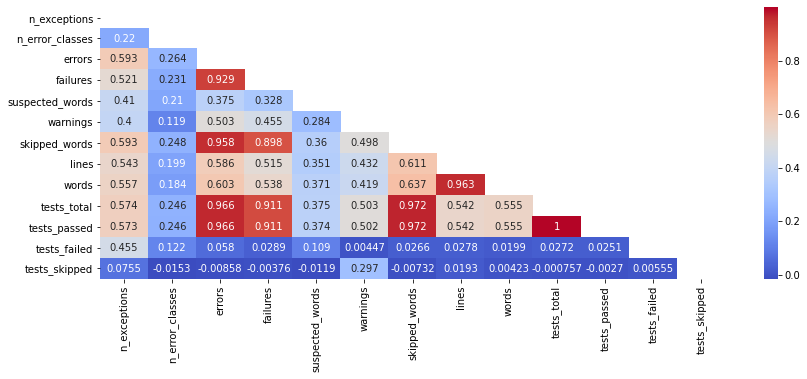

In [227]:
corr_matrix = job_parsed_no_empty[['n_exceptions', 'n_error_classes', 'errors', 'failures',
       'suspected_words', 'warnings', 'skipped_words', 'lines', 'words',
       'exceptions', 'error_classes', 'tests_total', 'tests_passed',
       'tests_failed', 'tests_skipped']].corr()
matrix = np.triu(corr_matrix)

plt.figure()
sns.heatmap(corr_matrix,annot = True, cmap= 'coolwarm',fmt='.3g', mask=matrix)
plt.savefig(f"{figure_folder}/log-parsing-analysis/pearson-correlation.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [163]:
job_parsed.tests_passed.corr(job_parsed.tests_total)

0.9999960746360489

In [164]:
(job_parsed.tests_passed/job_parsed.tests_total).corr(job_parsed.tests_total)

0.18313384181365383

**New features as a workaround for bad parsing**

In [165]:
job_parsed["errors_over_tests_total"] = job_parsed.errors / (job_parsed.tests_total+1)
job_parsed["failures_over_tests_total"] = job_parsed.failures / (job_parsed.tests_total+1)
job_parsed["skipped_over_tests_total"] = job_parsed.skipped_words / (job_parsed.tests_total+1)

In [166]:
job_parsed.columns

Index(['job_id', 'build_target', 'build_tool',
       'build_canceled_open_pr_on_branch', 'errors', 'failures',
       'suspected_words', 'warnings', 'skipped_words', 'lines', 'words',
       'exceptions', 'error_classes', 'tests_total', 'tests_passed',
       'tests_failed', 'tests_skipped', 'failed_tasks', 'build_tool_str',
       'n_exceptions', 'n_error_classes', 'n_build_tools', 'maven_build',
       'gradle_build', 'mocha_build', 'jest_build', 'grunt_build',
       'yarn_build', 'node_build', 'id', 'buildid', 'started_at', 'created_at',
       'finished_at', 'number', 'state', 'updated_at', 'commitsha', 'commitid',
       'commitmessage', 'commitref', 'commitcompare_url', 'year_month',
       'errors_over_tests_total', 'failures_over_tests_total',
       'skipped_over_tests_total'],
      dtype='object')

job_parsed_no_empty = job_parsed[job_parsed.lines > 1]
job_parsed_no_empty.shape

In [ ]:
job_parsed_no_empty.to_csv(f"{csv_folder}/log_parsed_metrics_processed.csv")

In [167]:
job_parsed["errors_over_tests_total"].corr(job_parsed.tests_passed)

-0.012582098549212488

In [168]:
job_parsed.tests_failed.corr(job_parsed.tests_total)

0.028753096263831268

In [169]:
job_parsed[job_parsed.tests_passed != job_parsed.tests_total]

,job_id,build_target,build_tool,build_canceled_open_pr_on_branch,errors,failures,suspected_words,warnings,skipped_words,lines,words,exceptions,error_classes,tests_total,tests_passed,tests_failed,tests_skipped,failed_tasks,build_tool_str,n_exceptions,n_error_classes,n_build_tools,maven_build,gradle_build,mocha_build,jest_build,grunt_build,yarn_build,node_build,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url,year_month,errors_over_tests_total,failures_over_tests_total,skipped_over_tests_total
0,346751001,WEB_TESTS,[yarn],False,3.0,2.0,1.0,2.0,1.0,1045.0,3294.0,[],[],1120.0,1117.0,0.0,3.0,[],['yarn'],0,0,1,False,False,False,False,False,True,False,346751001,346750998,2018-02-27 12:30:57+00:00,2018-02-27 12:30:21.579000+00:00,2018-02-27 12:34:24+00:00,37569.2,passed,2018-06-04 05:43:54.693000+00:00,7b245fbc45898ce11ab5cc0d60dc4f5621b94645,103144209,SONAR-10047 Use SearchSelect for tags in Bulk ...,refs/pull/3103/merge,https://github.com/SonarSource/sonarqube/pull/...,2018/02,0.002676,0.001784,0.000892
1,575471642,WEB_TESTS,"[yarn, jest, gradle]",False,3.0,2.0,1.0,9.0,1.0,1362.0,3919.0,[],[],2006.0,2005.0,0.0,1.0,[],"['yarn', 'jest', 'gradle']",0,0,3,False,True,False,True,False,True,False,575471642,575471639,2019-08-22 18:21:52+00:00,2019-08-22 18:21:19.464000+00:00,2019-08-22 18:33:18+00:00,39085.2,passed,2019-08-22 18:33:18.698000+00:00,7c2a234b30826c8f98dabff8506b1f49884b83a5,174121400,DOCS Add instructions for Application to a Por...,refs/heads/master,https://github.com/SonarSource/sonarqube/compa...,2019/08,0.001495,0.000997,0.000498
5,344358945,WEB_TESTS,[yarn],False,3.0,1.0,1.0,1.0,1.0,1021.0,3046.0,[],[],1120.0,1117.0,0.0,3.0,[],['yarn'],0,0,1,False,False,False,False,False,True,False,344358945,344358943,2018-02-21 15:04:07+00:00,2018-02-21 15:03:28.509000+00:00,2018-02-21 15:08:25+00:00,37376.2,passed,2018-06-04 04:48:01.848000+00:00,b5c52c888d50a13993f06e1d3373f8f1b7c1cbc1,102408031,Add a test case that updates pull request data,refs/pull/3091/merge,https://github.com/SonarSource/sonarqube/pull/...,2018/02,0.002676,0.000892,0.000892
7,354189360,WEB_TESTS,[yarn],False,3.0,1.0,1.0,2.0,1.0,1092.0,3389.0,[],[],1213.0,1210.0,0.0,3.0,[],['yarn'],0,0,1,False,False,False,False,False,True,False,354189360,354189358,2018-03-16 07:12:23+00:00,2018-03-16 07:11:50.387000+00:00,2018-03-16 07:16:09+00:00,38262.2,passed,2018-06-04 08:38:21.052000+00:00,98eb519207bea6c9bb3cc4a09419ec044cc2336c,105488877,SONAR-10439 Fix it test 2,refs/pull/3141/merge,https://github.com/SonarSource/sonarqube/pull/...,2018/03,0.002471,0.000824,0.000824
12,483557471,WEB_TESTS,"[yarn, jest, gradle]",False,2.0,2.0,1.0,9.0,1.0,1225.0,3587.0,[],[],1643.0,1641.0,0.0,2.0,[],"['yarn', 'jest', 'gradle']",0,0,3,False,True,False,True,False,True,False,483557471,483557469,2019-01-23 19:22:04+00:00,2019-01-23 19:21:25.856000+00:00,2019-01-23 19:29:59+00:00,38847.2,passed,2019-01-23 19:29:59.611000+00:00,3dc969856b59dc52b5b2e855d8b2387d4670ff36,145686653,DOCS formatting glitches & minor rewording (#1...,refs/pull/3187/merge,https://github.com/SonarSource/sonarqube/pull/...,2019/01,0.001217,0.001217,0.000608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136975,620789742,WEB_TESTS,"[yarn, gradle]",False,3.0,1.0,1.0,6.0,1.0,1450.0,3879.0,[],[],2179.0,2178.0,0.0,1.0,[],"['yarn', 'gradle']",0,0,2,False,True,False,False,False,True,False,620789742,620789740,2019-12-04 19:47:30+00:00,2019-12-04 19:46:24.462000+00:00,2019-12-04 19:56:09+00:00,39185.2,passed,2019-12-04 19:56:09.725000+00:00,5903d90c057cf58c17e32b4c5c20f87dd8e4f452,188691386,SONAR-12367 Show total issues in codeviewer he...,refs/heads/master,https://github.com/SonarSource/sonarqube/compa...,2019/12,0.001376,0.000459,0.000459
136979,338067370,BUILD,"[yarn, node, maven]",False,2417.0,2190.0,206.0,508.0

**Number of tests**

<AxesSubplot:>

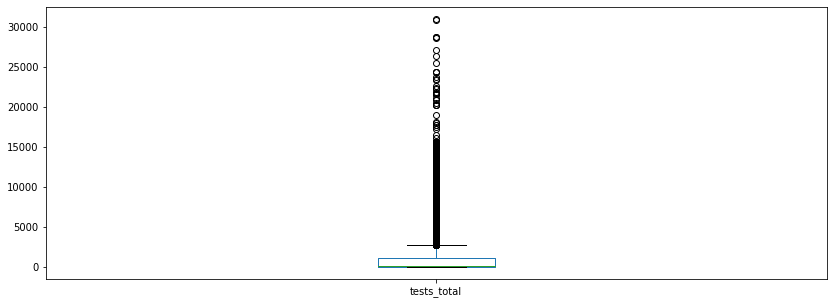

In [170]:
job_parsed.tests_total.plot(kind="box")

<AxesSubplot:>

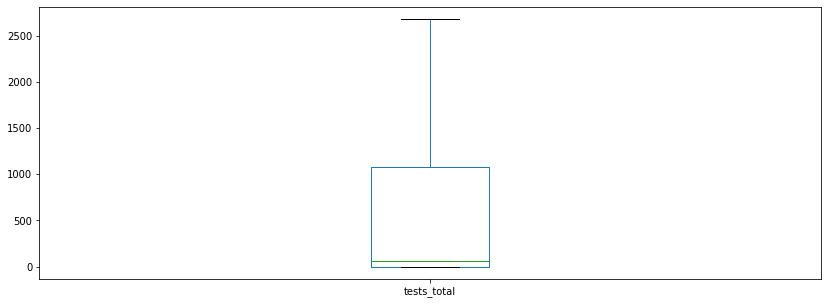

In [171]:
job_parsed.tests_total.plot(kind="box", showfliers=False)

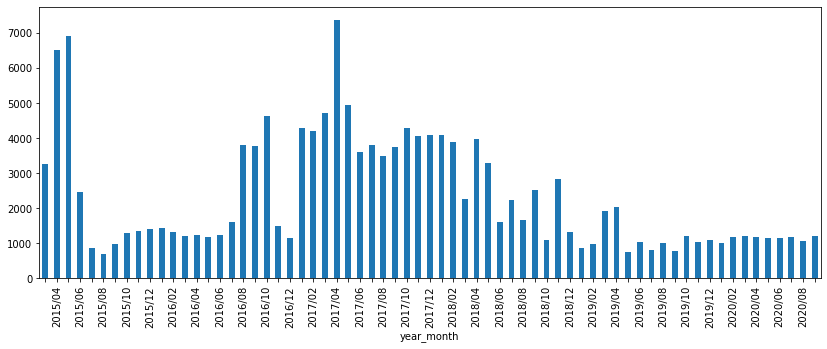

In [172]:
ax = job_parsed[job_parsed.year_month != "nan/nan"].groupby("year_month").tests_total.mean().plot(kind="bar")
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

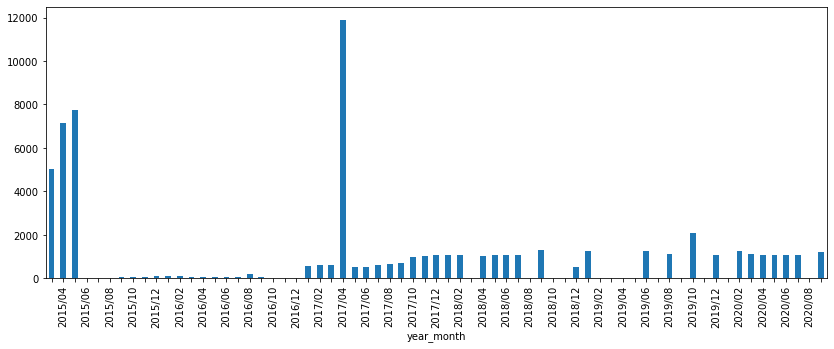

In [173]:
ax = job_parsed[job_parsed.year_month != "nan/nan"].groupby("year_month").tests_total.median().plot(kind="bar")
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

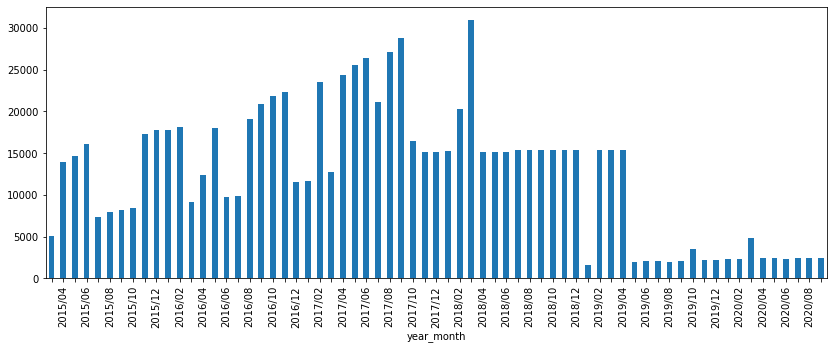

In [174]:
ax = job_parsed[job_parsed.year_month != "nan/nan"].groupby("year_month").tests_total.max().plot(kind="bar")
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

**Errors over tests**

In [175]:
job_parsed.errors_over_tests_total.describe()

count    136983.000000
mean          3.722524
std         146.030185
min           0.000000
25%           0.002793
50%           0.171507
75%           1.884615
max       14202.000000
Name: errors_over_tests_total, dtype: float64

<AxesSubplot:>

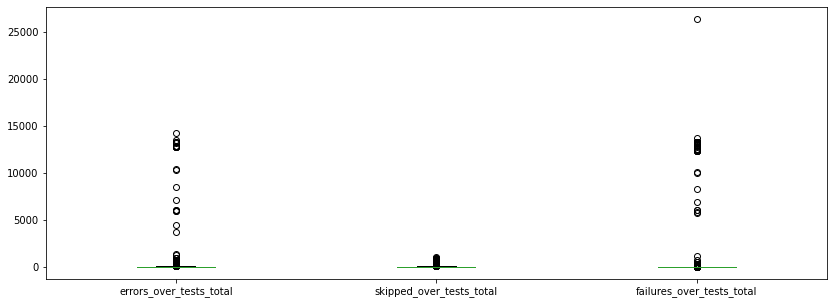

In [176]:
job_parsed[["errors_over_tests_total", "skipped_over_tests_total", "failures_over_tests_total"]].plot(kind="box")

In [177]:
job_parsed.loc[job_parsed.failures_over_tests_total.idxmax()]

job_id                                                                      221407116
build_target                                                                    BUILD
build_tool                                                                         []
build_canceled_open_pr_on_branch                                                False
errors                                                                            311
failures                                                                        26330
suspected_words                                                                    22
warnings                                                                           40
skipped_words                                                                       8
lines                                                                           54123
words                                                                          481122
exceptions                                            

**Exceptions thrown**

<AxesSubplot:>

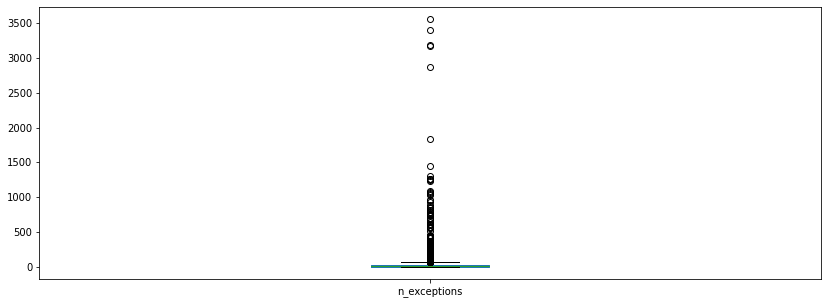

In [178]:
job_parsed.n_exceptions.plot(kind="box")

In [179]:
job_parsed[job_parsed.n_exceptions > 500].state.value_counts(normalize=True)
data = []
for i in range(0,3500,100):
    data.append((i, job_parsed[job_parsed.n_exceptions > i].state.value_counts(normalize=True)["failed"]))

<AxesSubplot:xlabel='n_exceptions'>

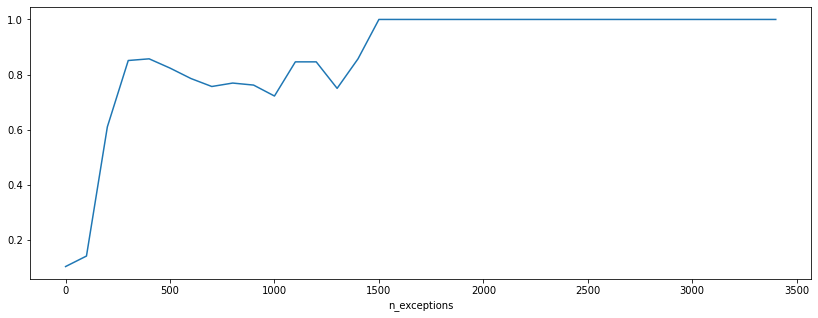

In [180]:
n_exceptions_failed_rate = pd.DataFrame(data, columns=["n_exceptions", "failed_jobs_rate"])
n_exceptions_failed_rate.set_index("n_exceptions")["failed_jobs_rate"].plot.line()

In [181]:
n_exceptions_failed_rate.n_exceptions.corr(n_exceptions_failed_rate.failed_jobs_rate)

0.7227653396855509

**Errors**

<AxesSubplot:>

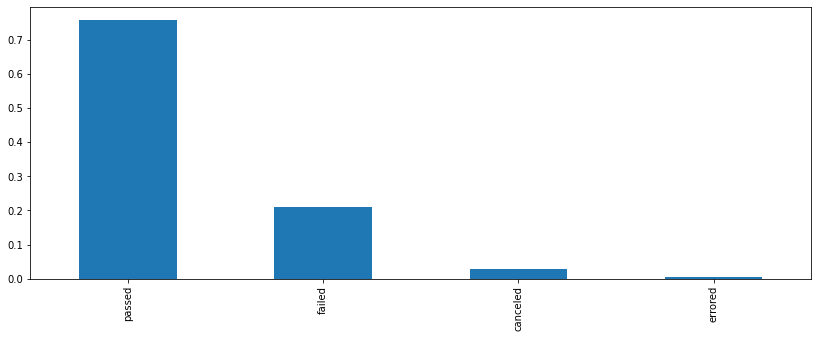

In [182]:
job_parsed[job_parsed.n_error_classes > 0].state.value_counts(normalize=True).plot(kind="bar")

**Warnings**

<AxesSubplot:>

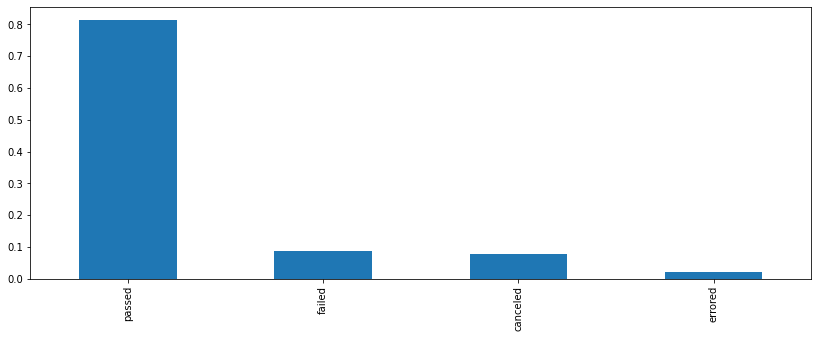

In [183]:
job_parsed[job_parsed.warnings > 0].state.value_counts(normalize=True).plot(kind="bar")

**Failures**

<AxesSubplot:>

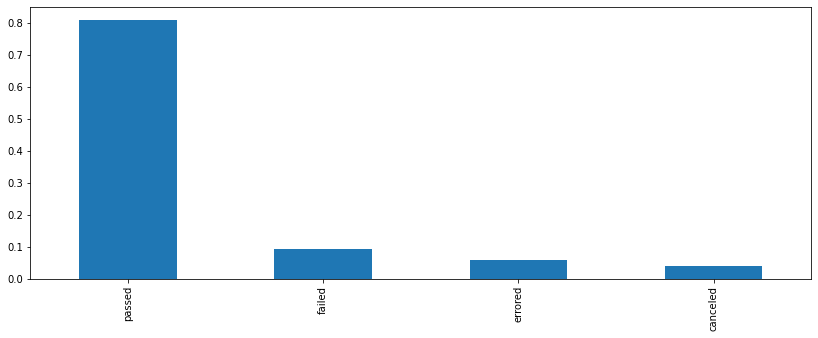

In [184]:
job_parsed[job_parsed.failures > 0].state.value_counts(normalize=True).plot(kind="bar")

**Number of test failed**

<AxesSubplot:xlabel='tests_failed'>

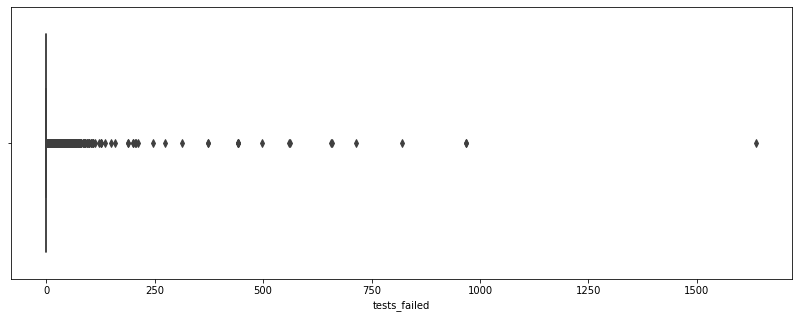

In [185]:
sns.boxplot(x=job_parsed.tests_failed)

<AxesSubplot:>

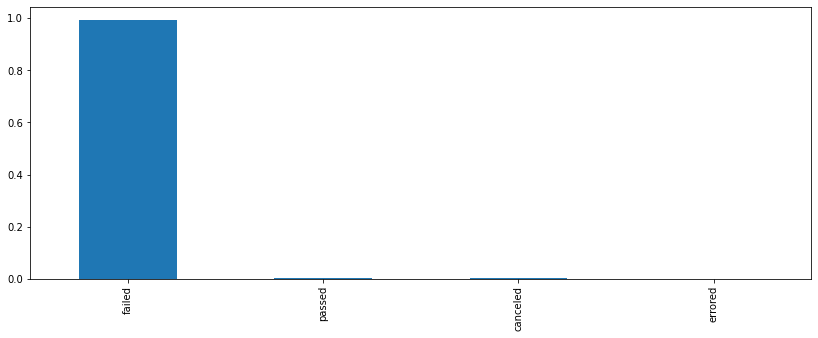

In [186]:
job_parsed[job_parsed.tests_failed > 0].state.value_counts(normalize=True).plot(kind="bar")

<AxesSubplot:>

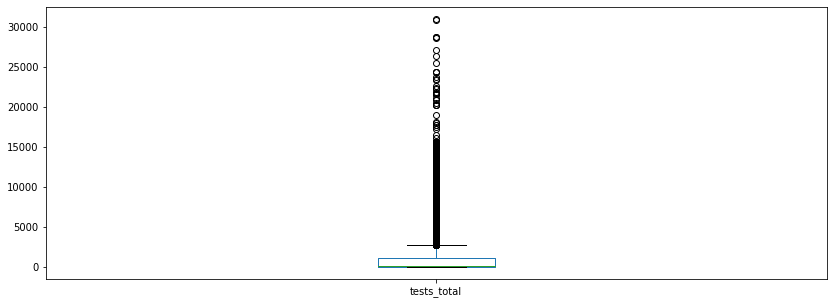

In [187]:
job_parsed.tests_total.plot(kind="box")

**Number of test failed**

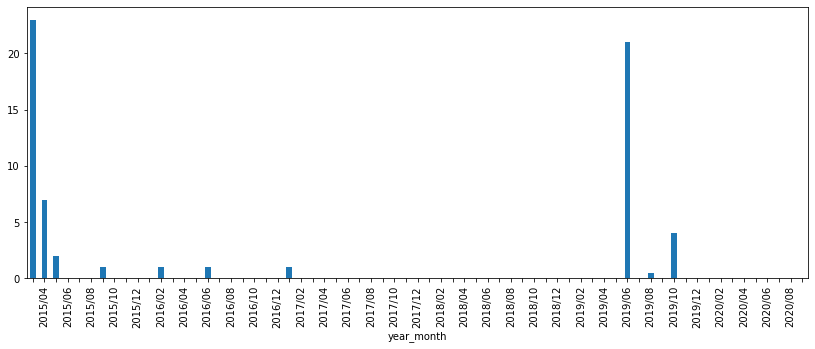

In [188]:
ax = job_parsed[job_parsed.year_month != "nan/nan"].groupby("year_month").tests_failed.quantile(0.95).plot(kind="bar")
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

<AxesSubplot:xlabel='tests_failed'>

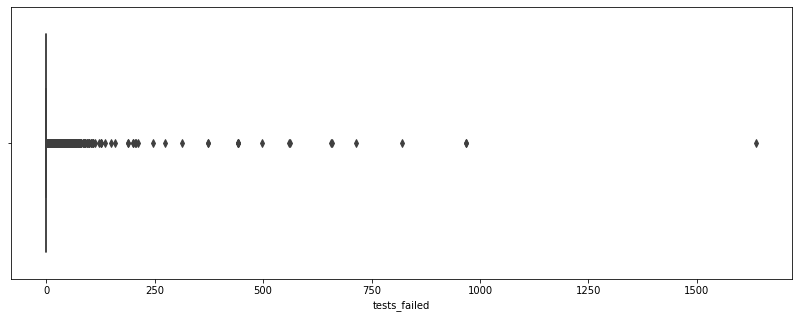

In [189]:
sns.boxplot(x=job_parsed.tests_failed)

**Distribution of build tools**

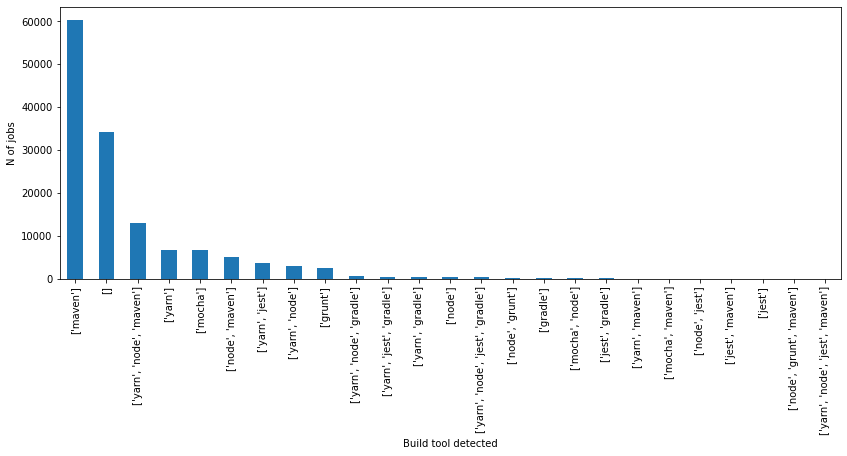

In [247]:
plt.figure()
ax = job_parsed.build_tool_str.value_counts().sort_values(ascending=False).plot(kind="bar")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set(xlabel="Build tool detected", ylabel="N of jobs")
plt.savefig(f"{figure_folder}/log-parsing-analysis/distribution_tools.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

**Yarn and Maven?**

In [192]:
yarn_maven = job_parsed[(job_parsed.build_tool.apply(lambda x: "yarn" in x)) \
           & (job_parsed.build_tool.apply(lambda x: "maven" in x))]

In [193]:
yarn_maven.build_target.value_counts()

BUILD    11537
CI        1445
Name: build_target, dtype: int64

In [194]:
yarn_maven.build_tool_str.value_counts()

['yarn', 'node', 'maven']            12969
['yarn', 'maven']                       14
['yarn', 'node', 'jest', 'maven']        2
Name: build_tool_str, dtype: int64

<AxesSubplot:>

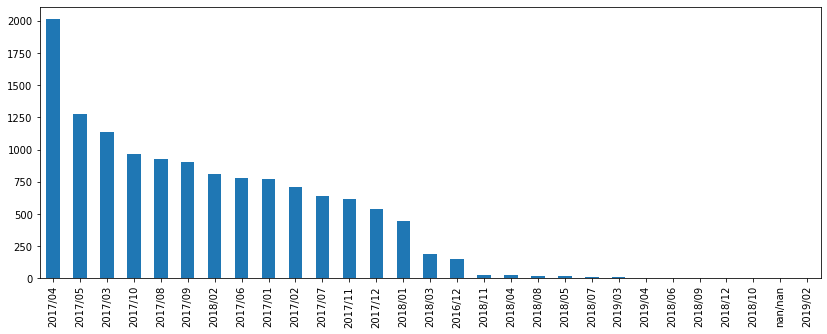

In [195]:
yarn_maven.year_month.value_counts().plot(kind="bar")

**Distribution build tools over time**

<Figure size 1008x360 with 0 Axes>

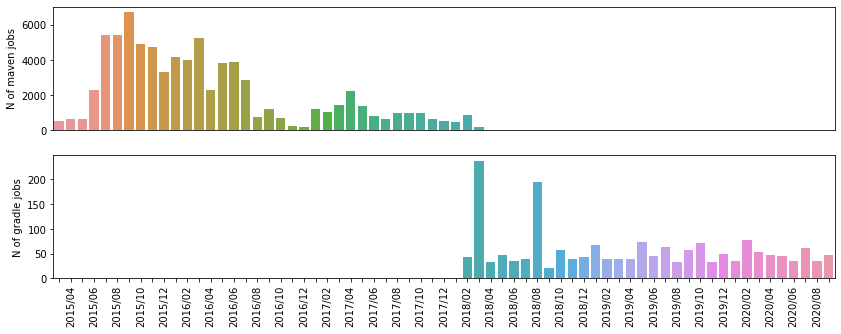

In [196]:
tools = ["maven","gradle"]
axis_title = ["N of maven jobs","N of gradle jobs"]
plt.figure()
fig, axes = plt.subplots(nrows=len(tools), ncols=1, sharex=True)
for i, tool in enumerate(tools):
    ax = sns.barplot(data=job_parsed[job_parsed.year_month != "nan/nan"]\
                     .groupby("year_month")[f"{tool}_build"].sum().reset_index(),\
                x='year_month', y=f"{tool}_build", ax=axes[i])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set(ylabel=axis_title[i], xlabel="")
    if(i < len(tools) - 1):
        ax.get_xaxis().set_visible(False)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
plt.savefig(f"{figure_folder}/log-parsing-analysis/maven-gradle.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

<Figure size 1008x360 with 0 Axes>

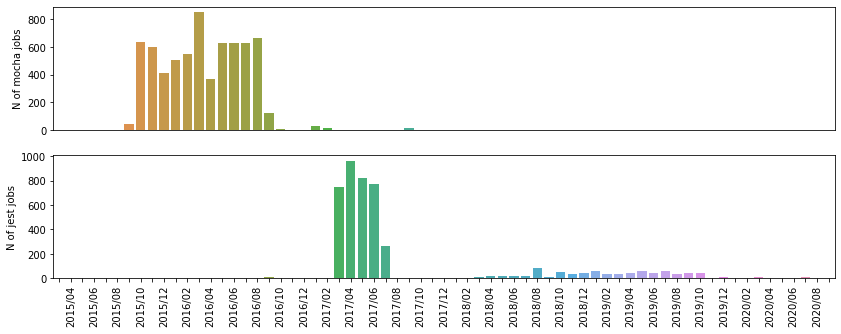

In [197]:
tools = ["mocha","jest"]
axis_title = ["N of mocha jobs","N of jest jobs"]
plt.figure()
fig, axes = plt.subplots(nrows=len(tools), ncols=1, sharex=True)
for i, tool in enumerate(tools):
    ax = sns.barplot(data=job_parsed[job_parsed.year_month != "nan/nan"]\
                     .groupby("year_month")[f"{tool}_build"].sum().reset_index(),\
                x='year_month', y=f"{tool}_build", ax=axes[i])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set(ylabel=axis_title[i], xlabel="")
    if(i < len(tools) - 1):
        ax.get_xaxis().set_visible(False)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
plt.savefig(f"{figure_folder}/log-parsing-analysis/mocha-jest.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

<Figure size 1008x360 with 0 Axes>

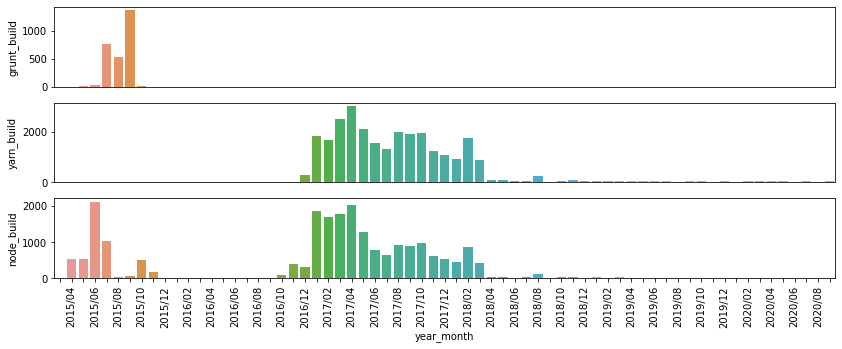

In [198]:
tools = ["grunt","yarn", "node"]
plt.figure()
fig, axes = plt.subplots(nrows=len(tools), ncols=1, sharex=True)
for i, tool in enumerate(tools):
    ax = sns.barplot(data=job_parsed[job_parsed.year_month != "nan/nan"]\
                     .groupby("year_month")[f"{tool}_build"].sum().reset_index(),\
                x='year_month', y=f"{tool}_build", ax=axes[i])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    if(i < len(tools) - 1):
        ax.get_xaxis().set_visible(False)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
plt.savefig(f"{figure_folder}/log-parsing-analysis/node-grunt-yarn.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

**Investigation of empty tools**

In [199]:
empty_build_tool = job_parsed[job_parsed.n_build_tools == 0]

In [200]:
empty_build_tool.state.value_counts(normalize=True)

canceled    0.554363
passed      0.244540
errored     0.177440
failed      0.023657
Name: state, dtype: float64

In [201]:
empty_build_tool_passed = empty_build_tool[empty_build_tool.state.isin(["passed"])]

In [202]:
empty_build_tool_failed = empty_build_tool[empty_build_tool.state.isin([ "failed"])]

**Are failed jobs with no build tool assigned shorter?**

<ipython-input-245-8290c8baba4e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_build_tool_failed["Build tool"] = "No tool detected"
<ipython-input-245-8290c8baba4e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_empty_build_tool_failed["Build tool"] = "Tool detected"


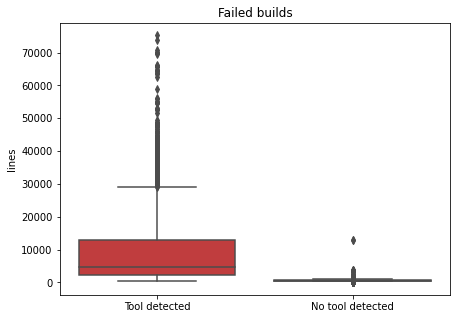

In [245]:
empty_build_tool_failed["Build tool"] = "No tool detected"
no_empty_build_tool_failed = job_parsed[(job_parsed.n_build_tools > 0)&(job_parsed.state.isin([ "failed"]))]
no_empty_build_tool_failed["Build tool"] = "Tool detected"

merged = no_empty_build_tool_failed.append(empty_build_tool_failed)
#Plot
plt.figure(figsize=(7,5))
ax = sns.boxplot(data=merged, x="Build tool", y="lines", color= matplotlib.colors.to_rgb('tab:red'))
ax.set(title="Failed builds", xlabel="")
plt.savefig(f"{figure_folder}/log-parsing-analysis/failed_empty_tool_lines.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

<AxesSubplot:xlabel='lines'>

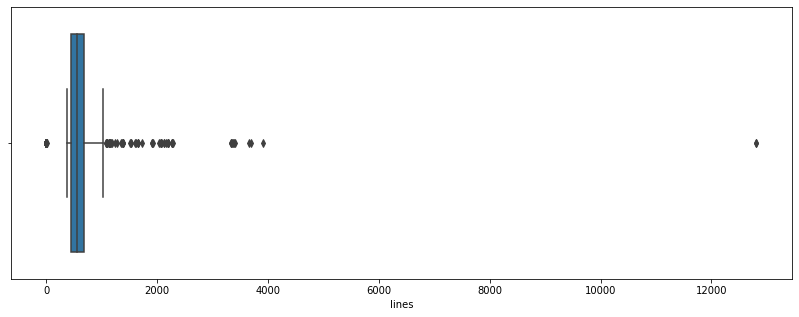

In [204]:
sns.boxplot(x=empty_build_tool_failed.lines)

Investigating outliers...

In [205]:
empty_build_tool_failed[empty_build_tool_failed.lines>12000]

,job_id,build_target,build_tool,build_canceled_open_pr_on_branch,errors,failures,suspected_words,warnings,skipped_words,lines,words,exceptions,error_classes,tests_total,tests_passed,tests_failed,tests_skipped,failed_tasks,build_tool_str,n_exceptions,n_error_classes,n_build_tools,maven_build,gradle_build,mocha_build,jest_build,grunt_build,yarn_build,node_build,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url,year_month,errors_over_tests_total,failures_over_tests_total,skipped_over_tests_total,Build tool
92794,224238385,BUILD,[],False,6057.0,6049.0,2.0,26.0,0.0,12812.0,117538.0,[],[],0.0,0.0,0.0,0.0,[],[],0,0,0,False,False,False,False,False,False,False,224238385,224238384,2017-04-21 06:47:03+00:00,2017-04-21 06:45:15.621000+00:00,2017-04-21 06:52:54+00:00,22555.1,failed,2018-06-02 07:26:11.198000+00:00,cb8951cc74049f7699eb3ffd76576d480e5be205,64745289,Force upgrade to Trusty,refs/heads/test/tv/ramfs,https://github.com/SonarSource/sonarqube/compa...,2017/04,6057.0,6049.0,0.0,No tool detected
97231,224253133,BUILD,[],False,6057.0,6049.0,2.0,26.0,0.0,12811.0,117569.0,[],[],0.0,0.0,0.0,0.0,[],[],0,0,0,False,False,False,False,False,False,False,224253133,224253132,2017-04-21 07:52:04+00:00,2017-04-21 07:50:28.328000+00:00,2017-04-21 07:57:54+00:00,22566.1,failed,2018-06-02 07:26:33.687000+00:00,c14b3f8e342fb0c30af3ef38970e42d3aeacb8a7,64750067,BUILD: fix travis install,refs/heads/test/tv/ramfs,https://github.com/SonarSource/sonarqube/compa...,2017/04,6057.0,6049.0,0.0,No tool detected


224253133, 224238385 are the only ones with no exceptions or error classes. They failed in running an intialization script which produced many lines of errors, and indeed the number of failure words is high.

**Passed jobs with no build tool**

In [206]:
empty_build_tool_passed.build_canceled_open_pr_on_branch.value_counts(normalize=True)

False    0.550468
True     0.449532
Name: build_canceled_open_pr_on_branch, dtype: float64

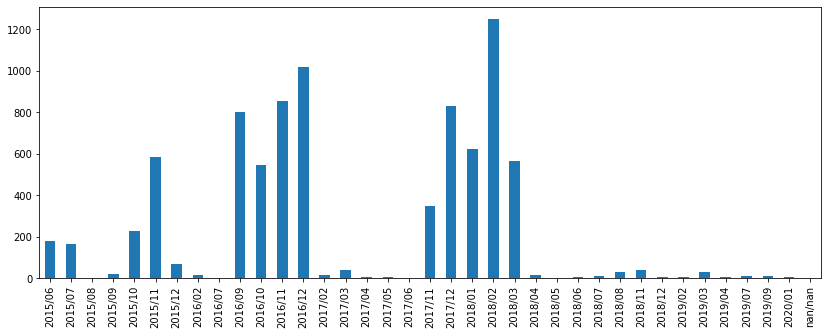

In [207]:
data = empty_build_tool_passed.year_month
ax = data.value_counts().sort_index().plot(kind="bar")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

<AxesSubplot:>

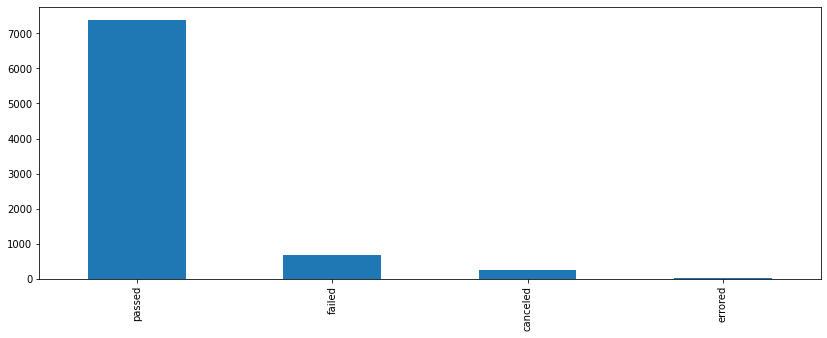

In [208]:
empty_build_tool_passed = empty_build_tool_passed.merge(builds[["id", "state"]], left_on="buildid", right_on="id", suffixes=["_job", "_build"])
empty_build_tool_passed.state_build.value_counts().plot(kind="bar")

In [209]:
empty_build_tool_passed = empty_build_tool_passed[~empty_build_tool_passed.build_canceled_open_pr_on_branch]

In [210]:
(empty_build_tool_passed.lines == 1).sum() / len(empty_build_tool_passed)

0.4181184668989547

In [211]:
empty_build_tool_passed[empty_build_tool_passed.lines > 1].shape

(2672, 48)

<ipython-input-246-c424afad9afa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_build_tool_passed_no_reason["Build tool"] = "No tool detected"
<ipython-input-246-c424afad9afa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_empty_build_tool_passed["Build tool"] = "Tool detected"


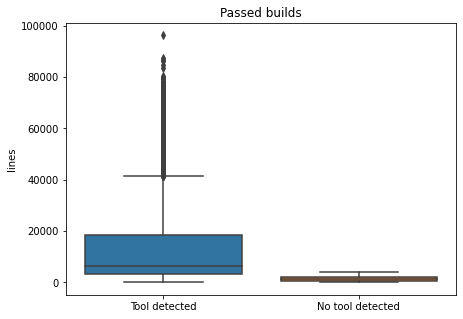

In [246]:
empty_build_tool_passed_no_reason = empty_build_tool_passed[(empty_build_tool_passed.lines>1)&\
                                                           (~empty_build_tool_passed.build_canceled_open_pr_on_branch)]
empty_build_tool_passed_no_reason["Build tool"] = "No tool detected"
no_empty_build_tool_passed = job_parsed[(job_parsed.n_build_tools > 0)&(job_parsed.state.isin(["passed"]))]
no_empty_build_tool_passed["Build tool"] = "Tool detected"

merged = no_empty_build_tool_passed.append(empty_build_tool_passed_no_reason)
#Plot
plt.figure(figsize=(7,5))
ax = sns.boxplot(data=merged, x="Build tool", y="lines")
ax.set(title="Passed builds", xlabel="")
plt.savefig(f"{figure_folder}/log-parsing-analysis/passed_empty_tool_lines.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

**Empty log file**

In [213]:
empty_log = job_parsed[job_parsed.lines==1]

In [214]:
len(job_parsed[job_parsed.lines==1]) / len(job_parsed)

0.07408218538066767

<AxesSubplot:>

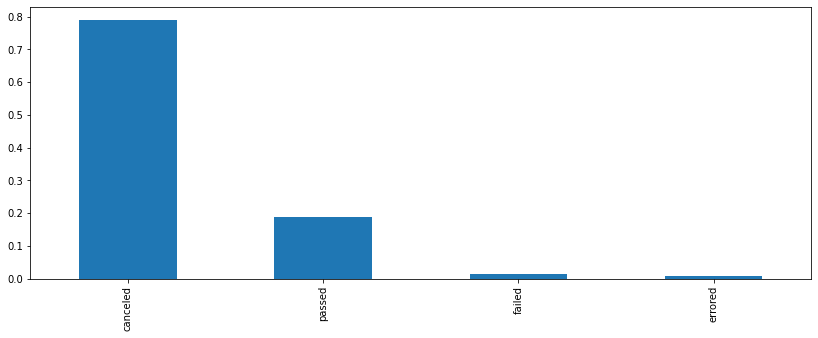

In [215]:
job_parsed[job_parsed.lines==1].state.value_counts(normalize=True).plot(kind="bar")

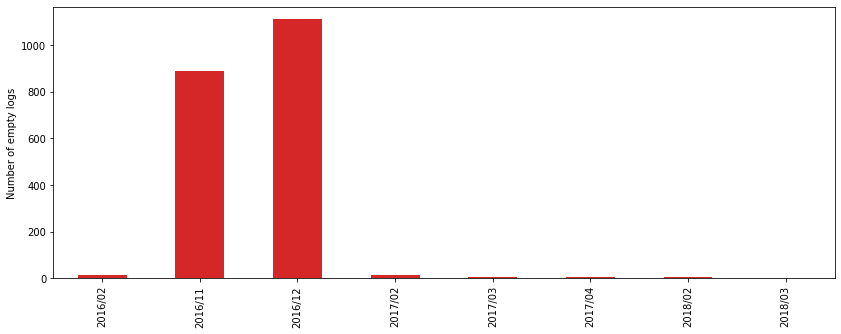

In [250]:
#Plot
plt.figure()
ax = empty_log[empty_log.state.isin(["passed", "failed"])].groupby("year_month").job_id.nunique().plot(kind="bar", color=["tab:red"])
ax.set(xlabel="", ylabel="Number of empty logs")
plt.savefig(f"{figure_folder}/log-parsing-analysis/empty_log_passed_failed_time_dist.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [248]:
empty_log[empty_log.year_month=="2016/12"]

,job_id,build_target,build_tool,build_canceled_open_pr_on_branch,errors,failures,suspected_words,warnings,skipped_words,lines,words,exceptions,error_classes,tests_total,tests_passed,tests_failed,tests_skipped,failed_tasks,build_tool_str,n_exceptions,n_error_classes,n_build_tools,maven_build,gradle_build,mocha_build,jest_build,grunt_build,yarn_build,node_build,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url,year_month,errors_over_tests_total,failures_over_tests_total,skipped_over_tests_total
80590,181403665,NaN,[],False,0.0,0.0,0.0,0.0,0.0,1.0,1.0,[],[],0.0,0.0,0.0,0.0,[],[],0,0,0,False,False,False,False,False,False,False,181403665,181403663,2016-12-05 17:01:29+00:00,2016-12-05 16:58:24.696000+00:00,2016-12-05 17:15:17+00:00,15733.1,failed,2018-06-01 16:25:09.426000+00:00,64ab9390063d9513104971166d5270d2b8952ed9,51776148,add more flow annotations,refs/pull/1417/merge,https://github.com/SonarSource/sonarqube/pull/...,2016/12,0.0,0.0,0.0
80591,181403667,NaN,[],False,0.0,0.0,0.0,0.0,0.0,1.0,1.0,[],[],0.0,0.0,0.0,0.0,[],[],0,0,0,False,False,False,False,False,False,False,181403667,181403663,2016-12-05 17:02:41+00:00,2016-12-05 16:58:24.735000+00:00,2016-12-05 17:08:53+00:00,15733.2,failed,2018-06-01 16:25:09.472000+00:00,64ab9390063d9513104971166d5270d2b8952ed9,51776148,add more flow annotations,refs/pull/1417/merge,https://github.com/SonarSource/sonarqube/pull/...,2016/12,0.0,0.0,0.0
80599,183959644,NaN,[],False,0.0,0.0,0.0,0.0,0.0,1.0,1.0,[],[],0.0,0.0,0.0,0.0,[],[],0,0,0,False,False,False,False,False,False,False,183959644,183959643,2016-12-14 15:38:26+00:00,2016-12-14 15:38:21.855000+00:00,2016-12-14 15:40:39+00:00,16133.1,canceled,2018-06-01 17:24:51.124000+00:00,0194307c03294c22a3d0158f16f22fbf01213f02,52520184,SONAR-7292 Sanitize IssuesWsParameters and use...,refs/heads/feature/jl/migrate_issues_comment_w...,https://github.com/SonarSource/sonarqube/compa...,2016/12,0.0,0.0,0.0
80600,183959645,NaN,[],False,0.0,0.0,0.0,0.0,0.0,1.0,1.0,[],[],0.0,0.0,0.0,0.0,[],[],0,0,0,False,False,False,False,False,False,False,183959645,183959643,2016-12-14 15:38:24+00:00,2016-12-14 15:38:21.875000+00:00,2016-12-14 15:40:39+00:00,16133.2,canceled,2018-06-01 17:24:51.140000+00:00,0194307c03294c22a3d0158f16f22fbf01213f02,52520184,SONAR-7292 Sanitize IssuesWsParameters and use...,refs/heads/feature/jl/migrate_issues_comment_w...,https://github.com/SonarSource/sonarqube/compa...,2016/12,0.0,0.0,0.0
80601,183959653,NaN,[],False,0.0,0.0,0.0,0.0,0.0,1.0,1.0,[],[],0.0,0.0,0.0,0.0,[],[],0,0,0,False,False,False,False,False,False,False,183959653,183959652,2016-12-14 15:38:27+00:00,2016-12-14 15:38:24.356000+00:00,2016-12-14 15:48:01+00:00,16134.1,failed,2018-06-01 17:24:51.195000+00:00,df2d4d1f7f92795a80d69975e862d2fe6a1c840f,52520185,SONAR-7292 Sanitize IssuesWsParameters and use...,refs/pull/1467/merge,https://github.com/SonarSource/sonarqube/pull/...,2016/12,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90570,181403600,NaN,[],False,0.0,0.0,0.0,0.0,0.0,1.0,1.0,[],[],0.0,0.0,0.0,0.0,[],[],0,0,0,False,False,False,False,False,False,False,181403600,181403598,2016-12-05 17:01:14+00:00,2016-12-05 16:58:17.947000+00:00,2016-12-05 17:03:37+00:00,15732.2,failed,2018-06-01 16:25:07.820000+00:00,0e78e4d13c9acc7baa7c95ebe1b7125775d2f362,51776143,add more flow annotations,refs/heads/feature/lambda/kill-ruby,https://github.com/SonarSource/sonarqube/compa...,2016/12,0.0,0.0,0.0
90571,182550488,NaN,[],False,0.0,0.0,0.0,0.0,0.0,1.0,1.0,[],[],0.0,0.0,0.0,0.0,[],[],0,0,0,False,False,False,False,False,False,False,182550488,182550487,2016-12-09 10:47:49+00:00,2016-12-09 10:47:46.597000+00:00,2016-12-09 10:53:07+00:00,15901.1,failed,2018-06-01 16:52:28.779000+00:00,c3478b8277ddebe61268b17f8778e04cf6311d93,52112334,fixup! DO NOT MERGE bump orches

**Sum of tests == total?**

In [217]:
not_na_job_parsed = job_parsed[~job_parsed.tests_total.isna()]
not_na_job_parsed[not_na_job_parsed.tests_total != (not_na_job_parsed.tests_passed + not_na_job_parsed.tests_skipped + not_na_job_parsed.tests_failed)]

,job_id,build_target,build_tool,build_canceled_open_pr_on_branch,errors,failures,suspected_words,warnings,skipped_words,lines,words,exceptions,error_classes,tests_total,tests_passed,tests_failed,tests_skipped,failed_tasks,build_tool_str,n_exceptions,n_error_classes,n_build_tools,maven_build,gradle_build,mocha_build,jest_build,grunt_build,yarn_build,node_build,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url,year_month,errors_over_tests_total,failures_over_tests_total,skipped_over_tests_total


We fixed this small bug. Just forgot to update passed tests for lines reporting only total, failed and skipped

**Reason for failing tests**

In [218]:
failed_jobs = job_parsed[job_parsed.state == "failed"]

In [219]:
len(failed_jobs[failed_jobs.tests_failed > 0]) / len(failed_jobs)

0.5084104707872997

In [220]:
len(failed_jobs[failed_jobs.failures > 0]) / len(failed_jobs)

0.9419727281775654

In [221]:
len(failed_jobs[failed_jobs.suspected_words > 0]) / len(failed_jobs)

0.9865631531800537

In [222]:
len(failed_jobs[failed_jobs.exceptions.apply(lambda x: len(x) > 0)]) / len(failed_jobs)

0.8093958395540958

In [223]:
len(failed_jobs[failed_jobs.error_classes.apply(lambda x: len(x) > 0)]) / len(failed_jobs)

0.350253807106599

In [224]:
len(failed_jobs[failed_jobs.errors > 0]) / len(failed_jobs)

0.9653627948641386

**Failed builds with no apparent reason**

In [225]:
failed_jobs = job_parsed[job_parsed.state == "failed"]

In [226]:
failed_jobs[(failed_jobs.tests_failed == 0) &\
           (failed_jobs.exceptions == "[]") &\
           (failed_jobs.error_classes == "[]")&\
           (failed_jobs.errors == 0) &\
           (failed_jobs.failures == 0) &\
           (failed_jobs.suspected_words == 0)].build_tool.value_counts()

Series([], Name: build_tool, dtype: int64)

All the failed build have no build tool and failed in the travis script before invoking one of the tools

**Gradle tests?**

In [135]:
gradle = job_parsed[job_parsed.build_tool.apply(lambda x: "gradle" in x)]
gradle[(gradle.tests_total > 0) & (gradle.build_target=="BUILD")]

,job_id,build_target,build_tool,build_canceled_open_pr_on_branch,errors,failures,suspected_words,warnings,skipped_words,lines,words,exceptions,error_classes,tests_total,tests_passed,tests_failed,tests_skipped,failed_tasks,build_tool_str,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url,n_exceptions,n_error_classes,n_build_tools,year_month,maven_build,gradle_build,mocha_build,jest_build,grunt_build,yarn_build,node_build
8,483557470,BUILD,"[yarn, node, jest, gradle]",False,2.0,5.0,3.0,12.0,0.0,1817.0,7496.0,"[FileNotFound, FileNotFound]",[],12.0,12.0,0.0,0.0,[],"['yarn', 'node', 'jest', 'gradle']",483557470,483557469,2019-01-23 19:21:55+00:00,2019-01-23 19:21:25.852000+00:00,2019-01-23 19:47:24+00:00,38847.1,passed,2019-01-23 19:47:24.747000+00:00,3dc969856b59dc52b5b2e855d8b2387d4670ff36,145686653,DOCS formatting glitches & minor rewording (#1...,refs/pull/3187/merge,https://github.com/SonarSource/sonarqube/pull/...,2,0,4,2019/01,False,True,False,True,False,True,True
14,432603264,BUILD,"[yarn, node, jest, gradle]",False,3.0,4.0,1.0,10.0,0.0,1377.0,5174.0,[],[],10.0,10.0,0.0,0.0,[],"['yarn', 'node', 'jest', 'gradle']",432603264,432603263,2018-09-24 18:21:55+00:00,2018-09-24 18:21:18.408000+00:00,2018-09-24 18:36:47+00:00,38673.1,passed,2018-09-24 18:36:47.761000+00:00,90c9dee7d1cd167658bb6be1a7554f9883d9b0c0,130098008,Do not execute Cirrus tasks on dogfood feature...,refs/heads/master,https://github.com/SonarSource/sonarqube/compa...,0,0,4,2018/09,False,True,False,True,False,True,True
48,461930847,BUILD,"[yarn, node, jest, gradle]",False,3.0,21.0,3.0,10.0,0.0,1718.0,7158.0,"[FileNotFound, FileNotFound]",[],12.0,12.0,0.0,0.0,[],"['yarn', 'node', 'jest', 'gradle']",461930847,461930846,2018-11-30 19:21:46+00:00,2018-11-30 19:21:14.748000+00:00,2018-11-30 19:46:05+00:00,38791.1,passed,2018-11-30 19:46:05.178000+00:00,9320207525a2645d835f19ff61c8dcb656f83e18,139137990,Fix Travis build,refs/heads/master,https://github.com/SonarSource/sonarqube/compa...,2,0,4,2018/11,False,True,False,True,False,True,True
66,431620486,BUILD,"[yarn, node, jest, gradle]",False,3.0,4.0,1.0,10.0,1.0,1384.0,5152.0,[],[],2.0,2.0,0.0,0.0,[],"['yarn', 'node', 'jest', 'gradle']",431620486,431620485,2018-09-21 18:21:43+00:00,2018-09-21 18:21:10.187000+00:00,2018-09-21 18:36:19+00:00,38672.1,passed,2018-09-21 18:36:19.794000+00:00,64d76164768f4b74d6bdc714191f65567baf8d10,129801286,rewrite account app in ts,refs/heads/master,https://github.com/SonarSource/sonarqube/compa...,0,0,4,2018/09,False,True,False,True,False,True,True
104,728138257,BUILD,"[yarn, node, jest, gradle]",False,3.0,10.0,12.0,29.0,0.0,1603.0,6218.0,[TestTimedOut],[],305.0,304.0,1.0,0.0,[server:sonar-main:test],"['yarn', 'node', 'jest', 'gradle']",728138257,728138256,2020-09-17 20:08:20+00:00,2020-09-17 20:07:47.760000+00:00,2020-09-17 20:24:47+00:00,39417.1,failed,2020-09-17 20:24:47.608000+00:00,eb9c975e8e8fd64381fd8d1ebea75989d298ac37,224801880,BUILD-811 Move ci builds to sonarqube team gcp...,refs/heads/branch-7.9,https://github.com/SonarSource/sonarqube/compa...,1,0,4,2020/09,False,True,False,True,False,True,True
110,430441025,BUILD,"[yarn, node, gradle]",False,4.0,10.0,1.0,3.0,0.0,1007.0,3665.0,[],"[Assertion, Assertion]",1171.0,1169.0,2.0,0.0,[sonar-plugin-api:test],"['yarn', 'node', 'gradle']",430441025,430441024,2018-09-19 08:52:56+00:00,2018-09-19 08:52:19.612000+00:00,2018-09-19 09:05:57+00:00,38669.1,failed,2018-09-19 09:05:57.714000+00:00,d26b9987f51a4866933b908dcc1d9a616994d28f,129436680,Revert unexpected changes in sonar-vsts/packag...,refs/heads/master,https://github.com/SonarSource/sonarqube/compa...,0,2,3,2018/09,False,True,False,False,False,True,True
247,492864642,BUILD,"[yarn, node, jest, gradle]",False,2.0,5.0,7.0,12.0,0.0,1683.0,6406.0,"[FileNotFound, FileNotFound]",[],12.0,12.0,0.0,0.0,[],"['yarn', 'node', 'jest', 'gradle']",492864642,492864641,2019-02-13 19:21:47+00:00,2019-02-13 19:21:10.957000+00

**Compare with Travistorrent**

In [ ]:
folder = "../../../../tmp"
df = pd.read_csv(f"{folder}/travis_projects.csv", index_col=0)
df

In [ ]:
sonar_travis = df[df.gh_project_name == "SonarSource/sonarqube"]

In [ ]:
sonar_travis.columns

In [ ]:
sonar_travis[["tr_job_id", "tr_log_num_tests_failed"]]

In [ ]:
job_our_travis = job_parsed[["job_id", "tests_failed","tests_skipped", "tests_passed","tests_total", "build_tool"]].merge(sonar_travis[["tr_log_analyzer", "tr_job_id", "tr_log_num_tests_failed", "tr_log_num_tests_run","tr_log_num_tests_ok", "tr_log_num_tests_skipped"]], left_on="job_id", right_on="tr_job_id")

In [ ]:
job_our_travis.shape

In [ ]:
job_our_travis[job_our_travis.tests_failed == job_our_travis.tr_log_num_tests_failed]

In [ ]:
x[(x.tests_passed != x.tr_log_num_tests_run) & (~x.tr_log_num_tests_run.isna())]

In [ ]:
job_parsed[job_parsed.build_tool.apply(lambda x: "gradle" in x)]

In [138]:
new_parsing = pd.read_csv("../../local_log_parsing/jobs_log_metrics_final.csv", index_col=0)

In [139]:
new_parsing.shape

(1845, 18)

In [141]:
new_parsing[new_parsing.tests_total == 6]

,job_id,build_target,build_tool,build_canceled_open_pr_on_branch,errors,failures,suspected_words,warnings,skipped_words,lines,words,exceptions,error_classes,tests_total,tests_passed,tests_failed,tests_skipped,failed_tasks
8,449986640,BUILD,"['yarn', 'node', 'jest', 'gradle']",False,24,43,4,30,13,9659,23388,"['FileNotFound', 'FileNotFound']",[],6,6,0,0,[]
11,511467601,BUILD,"['yarn', 'node', 'jest', 'gradle']",False,2,5,26,12,0,1701,6798,"['FileNotFound', 'FileNotFound']",[],6,6,0,0,[]
12,483557470,BUILD,"['yarn', 'node', 'jest', 'gradle']",False,2,5,3,12,0,1817,7496,"['FileNotFound', 'FileNotFound']",[],6,6,0,0,[]
37,503750852,BUILD,"['yarn', 'node', 'jest', 'gradle']",False,2,5,26,12,0,1708,6774,"['FileNotFound', 'FileNotFound']",[],6,6,0,0,[]
81,461930847,BUILD,"['yarn', 'node', 'jest', 'gradle']",False,3,21,3,10,0,1718,7158,"['FileNotFound', 'FileNotFound']",[],6,6,0,0,[]
129,472424947,BUILD,"['yarn', 'node', 'jest', 'gradle']",False,3,10,3,10,0,1711,7008,"['FileNotFound', 'FileNotFound']",[],6,6,0,0,[]
141,472425002,BUILD,"['yarn', 'node', 'jest', 'gradle']",False,3,10,3,10,0,1717,7026,"['FileNotFound', 'FileNotFound']",[],6,6,0,0,[]
176,492331709,BUILD,"['yarn', 'node', 'jest', 'gradle']",False,2,13,7,12,0,1851,6733,"['FileNotFound', 'FileNotFound']",[],6,6,0,0,[]
181,504865488,BUILD,"['yarn', 'node', 'jest', 'gradle']",False,2,5,26,12,0,1697,6757,"['FileNotFound', 'FileNotFound']",[],6,6,0,0,[]
216,460178328,BUILD,"['yarn', 'node', 'jest', 'gradle']",False,3,22,3,11,0,1870,8190,"['FileNotFound', 'FileNotFound']",[],6,6,0,0,[]


In [397]:
job_parsed[job_parsed.build_tool.apply(lambda x: "gradle" in x)].tests_passed.mean()

776.9691056910569

In [137]:
maven_ids = job_parsed[(job_parsed.build_tool.apply(lambda x: "gradle" in x))].job_id.unique()
with open('gradle_to_reparse.txt', 'w') as f:
    for item in maven_ids:
        f.write("%s\n" % item)

In [386]:
job_parsed[(job_parsed.build_tool.apply(lambda x: "gradle" in x)) &\
           (job_parsed.tests_total == 0)&\
           (job_parsed.build_tool.apply(lambda x: not "yarn" in x)) &\
           (job_parsed.build_target == "BUILD")].head(100)

,job_id,build_target,build_tool,build_canceled_open_pr_on_branch,errors,failures,suspected_words,warnings,skipped_words,lines,words,exceptions,error_classes,tests_total,tests_passed,tests_failed,tests_skipped,failed_tasks,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url,duration,n_exceptions,n_error_classes,n_build_tools,year_month,maven_build,gradle_build,mocha_build,jest_build,grunt_build,yarn_build,node_build,Build tool
100041,654868754,BUILD,[gradle],False,3.0,1.0,2.0,3.0,1.0,1676.0,7223.0,[],[],0.0,0.0,0.0,0.0,[],654868754,654868753,2020-02-25 12:19:26+00:00,2020-02-25 12:18:57.611000+00:00,2020-02-25 12:29:45+00:00,39258.1,passed,2020-02-25 12:29:45.938000+00:00,348572e537d52313ea949fae228ca5cb6ddf8f9a,199639121,Update run_iris.sh,refs/heads/feature/wad/do-not-merge-do-not-merge,https://github.com/SonarSource/sonarqube/compa...,619.0,0,0,1,2020/02,False,True,False,False,False,False,False,Tool detected
100044,539623711,BUILD,"[jest, gradle]",False,2.0,3.0,2.0,19.0,10.0,2450.0,11514.0,[],[],0.0,0.0,0.0,0.0,[],539623711,539623710,2019-05-31 09:33:00+00:00,2019-05-31 09:32:28.592000+00:00,2019-05-31 09:38:11+00:00,39002.1,failed,2019-05-31 09:38:12.011000+00:00,27fd75a5d1db1e617e15f609d8e0ea884442592c,163042815,Merge branch 'patch-1' of https://github.com/f...,refs/pull/3209/merge,https://github.com/SonarSource/sonarqube/pull/...,311.0,0,0,2,2019/05,False,True,False,True,False,False,False,Tool detected
100047,599916834,BUILD,"[jest, gradle]",False,2.0,2.0,21.0,40.0,1.0,2583.0,11358.0,[],[],0.0,0.0,0.0,0.0,[],599916834,599916833,2019-10-19 00:42:27+00:00,2019-10-19 00:41:57.220000+00:00,2019-10-19 00:55:24+00:00,39156.1,passed,2019-10-19 00:55:24.750000+00:00,9f78b9190e37cc87190161d19ed6e91396810261,181935164,fix: Test check against new wording,refs/pull/3230/merge,https://github.com/SonarSource/sonarqube/pull/...,777.0,0,0,2,2019/10,False,True,False,True,False,False,False,Tool detected
100054,654868799,BUILD,[gradle],False,2.0,1.0,1.0,3.0,1.0,1679.0,7219.0,[],[],0.0,0.0,0.0,0.0,[],654868799,654868798,2020-02-25 12:19:32+00:00,2020-02-25 12:19:01.138000+00:00,2020-02-25 12:29:35+00:00,39259.1,passed,2020-02-25 12:29:35.624000+00:00,7529bd4d4466fde00f4059cd2f143e92cd90cfee,199639128,Update run_iris.sh,refs/pull/3236/merge,https://github.com/SonarSource/sonarqube/pull/...,603.0,0,0,1,2020/02,False,True,False,False,False,False,False,Tool detected
100058,666960186,BUILD,"[jest, gradle]",False,3.0,6.0,8.0,17.0,36.0,6180.0,33799.0,"[FileNotFound, FileNotFound]",[],0.0,0.0,0.0,0.0,[],666960186,666960185,2020-03-25 20:04:41+00:00,2020-03-25 20:04:04.946000+00:00,2020-03-25 20:31:42+00:00,39283.1,passed,2020-03-25 20:31:42.675000+00:00,93bf42f81310013436f2d5ef60b60d8714a32f5f,203545004,increase analysis log level,refs/heads/branch-7.9,https://github.com/SonarSource/sonarqube/compa...,1621.0,2,0,2,2020/03,False,True,False,True,False,False,False,Tool detected
100091,728138203,BUILD,[gradle],False,99.0,8.0,3.0,8.0,46.0,9162.0,58707.0,[FileNotFound],[],0.0,0.0,0.0,0.0,[],728138203,728138202,2020-09-17 20:08:36+00:00,2020-09-17 20:07:36.568000+00:00,2020-09-17 20:30:12+00:00,39416.1,passed,2020-09-17 20:30:12.567000+00:00,2545e06845915284dfcacc23ed857a5f0cc2e5ab,224801847,SONAR-13867 revert,refs/heads/master,https://github.com/SonarSource/sonarqube/compa...,1296.0,1,0,1,2020/09,False,True,False,False,False,False,False,Tool detected
100175,634913519,BUILD,[gradle],False,2.0,6.0,14.0,15.0,8.0,2304.0,9377.0,[FileNotFound],[],0.0,0.0,0.0,0.0,[],634913519,634913518,2020-01-13 10:23:19+00:00,2020-01-09 19:46:24.834000+00:00,2020-01-13 10:48:28+00:00,39215.1,passed,2020-01-13 10:48:28.057000+00:00,f61e29bce771e56f8d45ad07a235c0399a1a9772,193210665,Fix codesmell typo (#2404),refs/heads/master,https://github.com/SonarSource/sonarqube/compa...,1509.0,1,0,1,2020/01,False,True,False,False,False,False,False,Tool detected
100240,634848325,BUILD,[gradle],False,2.0,1.0,36.0,5

In [377]:
job_parsed[job_parsed.job_id == 723216122]

,job_id,build_target,build_tool,build_canceled_open_pr_on_branch,errors,failures,suspected_words,warnings,skipped_words,lines,words,exceptions,error_classes,tests_total,tests_passed,tests_failed,tests_skipped,failed_tasks,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url,duration,n_exceptions,n_error_classes,n_build_tools,year_month,maven_build,gradle_build,mocha_build,jest_build,grunt_build,yarn_build,node_build,Build tool
105670,723216122,WEB_TESTS,"[yarn, gradle]",False,14.0,3.0,3.0,29.0,0.0,1429.0,4173.0,[],[],2421.0,2421.0,0.0,0.0,[],723216122,723216120,2020-09-01 20:08:30+00:00,2020-09-01 20:07:18.217000+00:00,2020-09-01 20:17:34+00:00,39404.2,passed,2020-09-01 20:17:36.236000+00:00,4bb0bd7d590110c6bc977eb480b30c67ef15e04d,223005970,Move ci builds to sonarqube team gcp project.,refs/heads/master,https://github.com/SonarSource/sonarqube/compa...,544.0,0,0,2,2020/09,False,True,False,False,False,True,False,Tool detected
